# Pre-work steps

In [ ]:
import pandas as pd

Defining Pandas display format

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 1000)

Cleaned DataFrames

In [ ]:
# orders_clean_df.csv
url = "https://drive.google.com/file/d/1ZEuWF3-pKYC-i6fP8unAAG_JMqU2KEyc/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders_cl = pd.read_csv(path)

# orderlines_clean_df.csv
url = "https://drive.google.com/file/d/1IbRAfLGhL7Yf_b8CVkknwhnzsdTBeCIt/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_cl = pd.read_csv(path)

# products_clean_df.csv
url = "https://drive.google.com/file/d/1tI_l4w1Nh5VjovBc60DCLdh1_OnpAXoN/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

# brands_clean_df.csv
url = "https://drive.google.com/file/d/1V33HMpSmSLjWSzmGv4is26QKIC_cqNpk/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
brands_cl = pd.read_csv(path)


Creating copies of the DataFrames for manipulation

In [ ]:
o_df=orders_cl.copy()
ol_df=orderlines_cl.copy()
p_df=products_cl.copy()
b_df=brands_cl.copy()

In [ ]:
o_df.shape

(40985, 4)

In [ ]:
ol_df.shape

(53231, 8)

In [ ]:
p_df.shape

(9992, 6)

Coverting dates to datetime

In [ ]:
o_df["created_date"]=pd.to_datetime(o_df["created_date"])
ol_df["date"]=pd.to_datetime(ol_df["date"])

# Processing DataFrames

### Filtering for "Completed" orders

In [ ]:
#original number of rows before filtering: 226904
#updated number of rows after filtering: 46605
o_df=o_df.query("state=='Completed'")

### Keeping only orders that are both in DataFrames **orders** and **orderlines**

In [ ]:
#original order_id nuniques in orders:46605
#original id_order nuniques in orderlines:170213
#merging DataFrames to identify order_id (unique) common in both
order_ids = o_df.merge(ol_df,
                left_on='order_id',
                right_on='id_order',
                how='inner')

In [ ]:
order_ids.shape

(53231, 12)

In [ ]:
order_ids = order_ids['order_id'].unique()

In [ ]:
# keeping only the common order_ids in orders
o_df = o_df.loc[o_df["order_id"].isin(order_ids), :]

# keeping only the common order_ids in orderlines
ol_df = ol_df.loc[ol_df["id_order"].isin(order_ids), :]

In [ ]:
#orders and orderlines now have same amount of unique order_ids
o_df["order_id"].nunique(), ol_df["id_order"].nunique()

(40985, 40985)

### Excluding orders with unknown products

Here we are looking for **"sku"** missing from the **products** DataFrame and deleting the assosiated **"order_id"** from **orderlines** and **orders**.

In [ ]:
#list of sku in the products
products_sku = p_df['sku'] #9992

#sku that are NOT in orderlines
orderlines_missing_products = ol_df[~ol_df['sku'].isin(products_sku)] #1394

#id_order for the sku in orderlines that are NOT in products
order_id_no_product = orderlines_missing_products['id_order'].unique() #1363

#removing from orderlines all id_order without a sku in products
ol_df = ol_df[~ol_df['id_order'].isin(order_id_no_product)] #54324 rows

#removing from orders all order_id without a sku in products
o_df = o_df[~o_df['order_id'].isin(order_id_no_product)] #41701 rows

In [ ]:
#orders and orderlines now have same number of unique id_order/order_id
ol_df["id_order"].nunique(),o_df["order_id"].nunique()

(40985, 40985)

### Creating a new calculated column for comparison

Creating a new column (**"unit_price_total"**) in orderlines with calculated data (**"unit_price"** * **"product_quantity"**) to be able to compare with **"total_paid"** in **orders** later.

In [ ]:
#creating a new column with values of the other two tables multiplied
ol_df.loc[:,'unit_price_total'] = ol_df['unit_price'] * ol_df['product_quantity']

In [ ]:
ol_df.columns

Index(['id', 'id_order', 'product_id', 'product_quantity', 'sku', 'unit_price',
       'date', 'unit_price_total'],
      dtype='object')

# Merged tables (for comparisons)

### DataFrame comparing total_paid with unit_price_total

1. Creating a new DataFrame, where **orderlines** is grouped by **"id_order"** and aggregated (summed) by column **"unit_price_total"**.
2. Merge **orders** to this new DataFrame to compare the values of columns **"total_paid"** (in **orders**) and **"unit_price_total"** (in **orderlines**).
3. This merged table should be **41701** rows long (due to the aggregated rows).

In [ ]:
#new grouped and aggregated DataFrame
#41701 rows
ol_agg = ol_df.groupby("id_order", as_index=False)["unit_price_total"].sum()

In [ ]:
ol_agg_o = ol_agg.merge(o_df, left_on="id_order", right_on="order_id") #41701 rows

In [ ]:
ol_agg_o = o_df.merge(ol_agg, left_on="order_id", right_on="id_order")

In [ ]:
ol_agg_o_dif = ol_agg_o.copy()

In [ ]:
#difference between total_paid and unit_price_total
ol_agg_o_dif["order_price_dif"] = ol_agg_o["total_paid"] - ol_agg_o["unit_price_total"]

In [ ]:
#average difference between total_paid and unit_price_total
ol_agg_o_dif.order_price_dif.mean().round(2)

3.94

### DataFrame comparing price with unit_price

1. Create another new DataFrame, where the **products** DataFrame is now merged with the **orderlines** table.
2. Compare the values of columns **"price"** (in products) and **"unit_price"** (in orderlines).
3. This merged table should be **54324** as the rows are not aggregated.

In [ ]:
#new DataFrame with products merged to orderlines
#54324 rows
ol_p = ol_df.merge(p_df,
                on='sku',
                how='left') #54324

In [ ]:
ol_p_dif = ol_p.copy()

In [ ]:
#difference between price and unit_price
#the difference should be explained by a promotion
ol_p_dif["unit_price_dif"] = ol_p["price"] - ol_p["unit_price"]

In [ ]:
#average difference between price and unit_price
ol_p_dif.unit_price_dif.mean().round(2)

26.12

# Distribution of data

We will now look at the data to see if there are any outliers.  For this we could use histograms or other plotting visualization approaches.

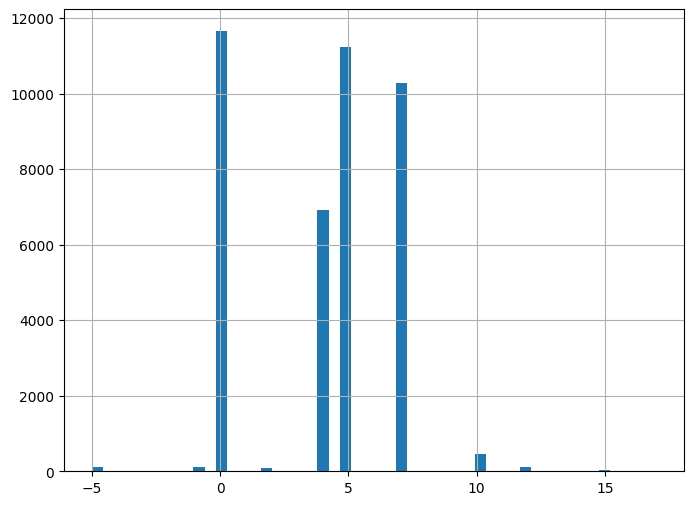

In [ ]:
#looking at difference between total_paid and unit_price_total
ol_agg_o_dif["order_price_dif"].hist(bins= 50, figsize=(8,6));

In [ ]:
ol_agg_o_dif["order_price_dif"].describe()

,order_price_dif
count,40985.00
mean,3.94
std,2.83
min,-5.00
25%,0.00
50%,4.99
75%,6.99
max,16.97


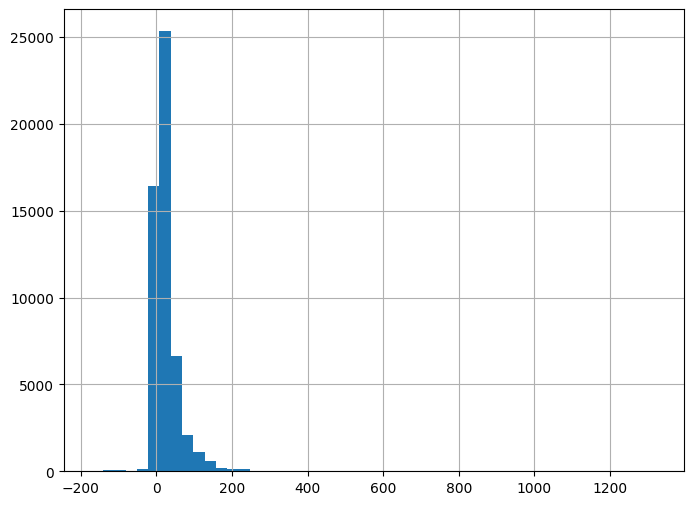

In [ ]:
#looking at difference between price and unit_price
ol_p_dif["unit_price_dif"].hist(bins= 50, figsize=(8,6));

In [ ]:
#these differences seem to make sense as discounts/promo prices
ol_p_dif["unit_price_dif"].describe()

,unit_price_dif
count,53231.00
mean,26.12
std,45.55
min,-170.99
25%,5.25
50%,15.00
75%,31.00
max,1320.00


# Addressing outliers

### Deleting outliers (below 25% and above 75%)

In [ ]:
# Removing outliers from ol_agg_o_diff (orderlines aggregated and merged with orders, dif between total_price and unit_price_total)

# Calculating Q1 (25th percentile) and Q3 (75th percentile)
Q1 = ol_agg_o_dif["order_price_dif"].quantile(0.25)
Q3 = ol_agg_o_dif["order_price_dif"].quantile(0.75)
IQR = Q3 - Q1

# Defining the outlier range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering the DataFrame to remove outliers
ol_agg_o_dif_no_outliers = ol_agg_o_dif[(ol_agg_o_dif["order_price_dif"] >= lower_bound) & (ol_agg_o_dif["order_price_dif"] <= upper_bound)]

In [ ]:
#checking again for outliers
ol_agg_o_dif_no_outliers["order_price_dif"].describe()

,order_price_dif
count,40985.00
mean,3.94
std,2.83
min,-5.00
25%,0.00
50%,4.99
75%,6.99
max,16.97


<Axes: >

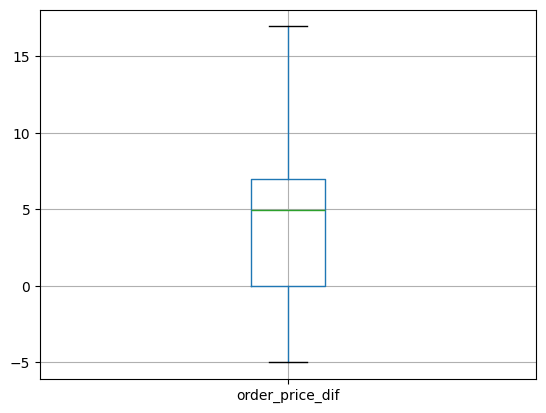

In [ ]:
#checking again for outliers (boxplot)
ol_agg_o_dif_no_outliers.boxplot("order_price_dif")

In [ ]:
#after removing outliers, the DataFrame is down to 40985 rows
ol_agg_o_dif_no_outliers.shape

(40985, 7)

### Removing order_id outliers everywhere

Removing the outliers' unique order_id/id_order from **orders** as well as from **orderlines_products** *merged* DataFrame.

In [ ]:
normal_diff_list = ol_agg_o_dif_no_outliers["id_order"]

In [ ]:
o_df = o_df.loc[o_df["order_id"].isin(normal_diff_list),:]

In [ ]:
ol_df = ol_df.loc[ol_df["id_order"].isin(normal_diff_list),:]

In [ ]:
o_df["order_id"].nunique(), ol_df["id_order"].nunique()

(40985, 40985)

# Final reliable DataFrames

In [ ]:
#saving the cleaned orders DataFrame as .csv
o_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Eniac/Eniac_exploration_cleaning/orders_clean_df.csv', index=False)
#saving the cleaned orderlines DataFrame as .csv
ol_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Eniac/Eniac_exploration_cleaning/orderlines_clean_df.csv', index=False)
#saving the cleaned products DataFrame as .cvs
p_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Eniac/Eniac_exploration_cleaning/products_clean_df.csv', index=False)
#saving the cleaned brands DataFrame as .cvs
b_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Eniac/Eniac_exploration_cleaning/brands_clean_df.csv', index=False)

In [ ]:
#verifying copying was successful for the first DataFrame (orders)
df_verify = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Eniac/Eniac_exploration_cleaning/orders_clean_df.csv')
print(df_verify)

       order_id         created_date  total_paid      state
0        241423  2017-11-06 13:10:02      136.15  Completed
1        242832  2017-12-31 17:40:03       15.76  Completed
2        243330  2017-02-16 10:59:38       84.98  Completed
3        245275  2017-06-28 11:35:37      149.00  Completed
4        245595  2017-01-21 12:52:47      112.97  Completed
...         ...                  ...         ...        ...
40980    527042  2018-03-14 11:47:50       18.98  Completed
40981    527070  2018-03-14 11:50:48       24.97  Completed
40982    527074  2018-03-14 11:51:42       24.97  Completed
40983    527096  2018-03-14 11:58:40       34.96  Completed
40984    527112  2018-03-14 12:03:52       14.98  Completed

[40985 rows x 4 columns]


In [ ]:
#verifying copying was successful for the second DataFrame (orderlines)
df_verify = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Eniac/Eniac_exploration_cleaning/orderlines_clean_df.csv')
print(df_verify)

            id  id_order  product_id  product_quantity        sku  unit_price  \
0      1119116    299545           0                 1    OWC0100       47.49   
1      1119119    299546           0                 1    IOT0014       18.99   
2      1119120    295347           0                 1    APP0700       72.19   
3      1119134    299556           0                 1  CRU0039-A       60.90   
4      1119145    299561           0                 1    PEB0015      142.49   
...        ...       ...         ...               ...        ...         ...   
53226  1649447    527035           0                 1    APP0698        9.99   
53227  1649512    527070           0                 2    APP0698        9.99   
53228  1649522    527074           0                 2    APP0698        9.99   
53229  1649565    527096           0                 3    APP0698        9.99   
53230  1649593    527112           0                 1    APP0698        9.99   

                      date 

In [ ]:
#verifying copying was successful for the third DataFrame (products)
df_verify = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Eniac/Eniac_exploration_cleaning/products_clean_df.csv')
print(df_verify)

          sku                                           name  \
0     RAI0007              Silver Rain Design mStand Support   
1     APP0023              Apple Mac Keyboard Keypad Spanish   
2     APP0025               Mighty Mouse Apple Mouse for Mac   
3     APP0072  Apple Dock to USB Cable iPhone and iPod white   
4     KIN0007    Mac Memory Kingston 2GB 667MHz DDR2 SO-DIMM   
...       ...                                            ...   
9987  BEL0376        Belkin Travel Support Apple Watch Black   
9988  THU0060   Enroute Thule 14L Backpack MacBook 13 "Black   
9989  THU0061    Enroute Thule 14L Backpack MacBook 13 "Blue   
9990  THU0062     Enroute Thule 14L Backpack MacBook 13 "Red   
9991  THU0063   Enroute Thule 14L Backpack MacBook 13 "Green   

                                                   desc  price  in_stock  \
0          Aluminum support compatible with all MacBook  59.99         1   
1             USB ultrathin keyboard Apple Mac Spanish.  59.00         0   
2  

In [ ]:
#verifying copying was successful for the forth DataFrame (brands)
df_verify = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Eniac/Eniac_exploration_cleaning/brands_clean_df.csv')
print(df_verify)

    short              long
0     8MO         8Mobility
1     ACM              Acme
2     ADN            Adonit
3     AII             Aiino
4     AKI            Akitio
5     ALL         Allocacoc
6     AP2             Apple
7     APP             Apple
8     BAN        Band&Strap
9     BEA             Beats
10    BEL            Belkin
11    BEZ             Be.ez
12    BLL        BlueLounge
13    BLM  Blue Microphones
14    BNQ              BenQ
15    BOD        BodyGuardz
16    BOO              Booq
17    BOS              Bose
18    BTC         Boostcase
19    CAD              Bose
20    CAI          Casetify
21    CEL             Celly
22    COG            Cogito
23    CRU           Crucial
24    CYB        Cyberpower
25    CYG           Cygnett
26    DEV            Devolo
27    DJI               DJI
28    DLK            D-Link
29    DLL              Dell
30    DOD          Dodocool
31    DRO             Drobo
32    DVI             Devia
33    EIZ              Eizo
34    ELA           